In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
TARGET_FEATURE_NAME = "label"
TARGET_FEATURE_LABELS = ["0", "1"]
NUM_CLASSES = len(TARGET_FEATURE_LABELS)

# Numeric Feature
NUMERIC_FEATURE_NAMES = [
    'movieAvgRating',
    'movieRatingStddev',
    'movieRatingCount',
    'userAvgRating',
    'userRatingStddev',
    'userRatingCount',
    'releaseYear',
]

# ID Feature
ID_FEATURE_NAMES = ['movieId', 'userId']

# Categorical Feature
genre_vocab = ['Film-Noir', 'Action', 'Adventure', 
               'Horror', 'Romance', 'War', 
               'Comedy', 'Western', 'Documentary',
               'Sci-Fi', 'Drama', 'Thriller',
               'Crime', 'Fantasy', 'Animation', 
               'IMAX', 'Mystery', 'Children', 'Musical']

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    'userGenre1': genre_vocab,
    'userGenre2': genre_vocab,
    'userGenre3': genre_vocab,
    'userGenre4': genre_vocab,
    'userGenre5': genre_vocab,
    'movieGenre1': genre_vocab,
    'movieGenre2': genre_vocab,
    'movieGenre3': genre_vocab
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES + ID_FEATURE_NAMES

# 读取CSV时的缺失值填充
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in FEATURE_NAMES
]

In [3]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = keras.layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            inputs[feature_name] = keras.layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
        if feature_name in ID_FEATURE_NAMES:
            inputs[feature_name] = keras.layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [4]:
def encode_mlp_inputs(inputs):
    encoded_cols = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            cat_col = tf.feature_column.categorical_column_with_hash_bucket(
                key=feature_name, hash_bucket_size=10)
            emb_col = tf.feature_column.embedding_column(cat_col, 10)
            
        elif feature_name in ID_FEATURE_NAMES:
            cat_col = tf.feature_column.categorical_column_with_hash_bucket(
                key=feature_name, hash_bucket_size=1000)
            emb_col = tf.feature_column.embedding_column(cat_col, 10)
            
        elif feature_name in NUMERIC_FEATURE_NAMES:
            # 在最后增加一维
            emb_col = tf.feature_column.numeric_column(feature_name)
#             emb_col = tf.expand_dims(inputs[feature_name], -1)
        encoded_cols.append(emb_col)
#     all_features = keras.layers.concatenate(encoded_cols)
    return encoded_cols

In [5]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 12
num_epochs = 3

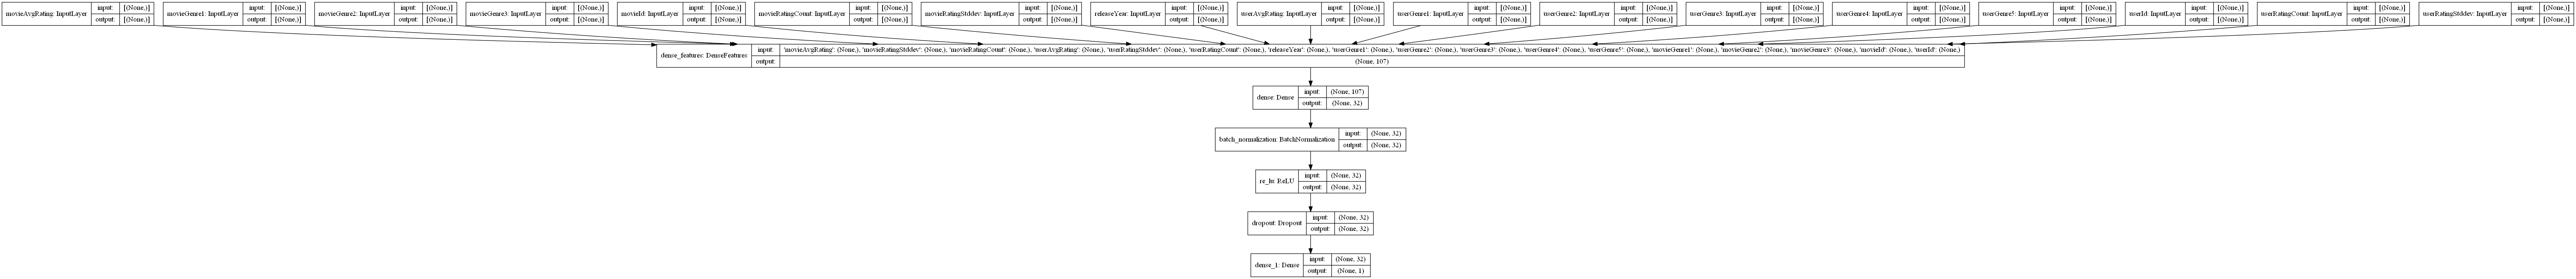

In [6]:
hidden_units = [32]
def create_MLP_model():
    inputs = create_model_inputs()
    features = encode_mlp_inputs(inputs)
    ff_layer = tf.keras.layers.DenseFeatures(features)(inputs)
#     features = encode_mlp_inputs(inputs)
    for units in hidden_units:
        ff_layer = keras.layers.Dense(units)(ff_layer)
        ff_layer = keras.layers.BatchNormalization()(ff_layer)
        ff_layer = keras.layers.ReLU()(ff_layer)
        ff_layer = keras.layers.Dropout(dropout_rate)(ff_layer)
        
    outputs = keras.layers.Dense(1, activation="sigmoid")(ff_layer)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

MLP_model = create_MLP_model()
keras.utils.plot_model(MLP_model, show_shapes=True, rankdir="TB")

In [7]:
training_samples_file_path = './sampledata/trainingSamples.csv'
test_samples_file_path = './sampledata/testSamples.csv'

def get_dataset(file_path, batch_size):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=batch_size,
        label_name='label',
        na_value="0",
        num_epochs=1,
        ignore_errors=True)
    return dataset.cache()

batch_size = 128
# split as test dataset and training dataset
train_dataset = get_dataset(training_samples_file_path, batch_size)
test_dataset = get_dataset(test_samples_file_path, batch_size)

In [8]:
def run_experiment(model): 
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')],
    )
    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy, _, _ = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [9]:
run_experiment(MLP_model)

Start training the model...
Epoch 1/3


D:\Conda\envs\studio\lib\site-packages\tensorflow\python\keras\engine\functional.py:595: UserWarning: Input dict contained keys ['rating', 'timestamp', 'userRatedMovie1', 'userRatedMovie2', 'userRatedMovie3', 'userRatedMovie4', 'userRatedMovie5', 'userAvgReleaseYear', 'userReleaseYearStddev'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


694/694 [==============================] - 7s 5ms/step - loss: 0.6656 - accuracy: 0.5893 - auc: 0.6183 - auc_1: 0.6726
Epoch 2/3
694/694 [==============================] - 4s 6ms/step - loss: 0.6208 - accuracy: 0.6551 - auc: 0.7046 - auc_1: 0.7403
Epoch 3/3
694/694 [==============================] - 4s 6ms/step - loss: 0.6013 - accuracy: 0.6798 - auc: 0.7341 - auc_1: 0.7607
Model training finished
Test accuracy: 63.24%
